#### Import libraries:

In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from porousmedialab.column import Column

#### Setting up the properties of time-space and create the domain:

In [2]:
t = 27 / 365
dx = 0.2
L = 40
phi = 0.8
dt = 1e-5
ftc = Column(L, dx, t, dt)

#### To make things interesting lets create not simple inital conditions for iron:

In [3]:
x = np.linspace(0, L, L / dx + 1)
Fe3_init = np.zeros(x.size)
Fe3_init[x > 5] = 75
Fe3_init[x > 15] = 0
Fe3_init[x > 25] = 75
Fe3_init[x > 35] = 0

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


#### Adding species with names, diffusion coefficients, initial concentrations and boundary top and bottom conditions:

In [4]:
ftc.add_species(theta=phi, name='O2', D=368, init_conc=0, bc_top_value=0.231, bc_top_type='dirichlet', bc_bot_value=0, bc_bot_type='flux')
ftc.add_species(theta=phi, name='CO2', D=320, init_conc=0, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
ftc.add_species(theta=phi, name='Fe2', D=127, init_conc=0, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')

ftc.add_species(theta=1-phi, name='OM', D=1e-18, init_conc=15, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
ftc.add_species(theta=1-phi, name='FeOH3', D=1e-18, init_conc=Fe3_init, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')


#### Specify the constants used in the rates:

In [5]:
ftc.constants['k_OM'] = 1
ftc.constants['Km_O2'] = 20e-3
ftc.constants['Km_FeOH3'] = 10
ftc.constants['k8'] = 1.4e+5
ftc.constants['Q10'] = 4  ### added
ftc.constants['CF'] = (1-phi)/phi  ### conversion factor

### Simulate Temperature with thermal diffusivity coefficient 281000 and init and boundary temperature 5C:

In [8]:
ftc.add_species(theta=0.99, name='Temperature', D=281000, init_conc=5, bc_top_value=5., bc_top_type='constant', bc_bot_value=0, bc_bot_type='flux')

#### Add Q10 factor:

In [9]:
ftc.rates['R1'] = 'Q10**((Temperature-5)/10) * k_OM * OM * O2 / (Km_O2 + O2)'
ftc.rates['R2'] = 'Q10**((Temperature-5)/10) * k_OM * OM * FeOH3 / (Km_FeOH3 + FeOH3) * Km_O2 / (Km_O2 + O2)'
ftc.rates['R8'] = 'k8 * O2 * Fe2'

#### ODEs for specific species:

In [10]:
ftc.dcdt['OM'] = '-R1-R2'
ftc.dcdt['O2'] = '-R1-R8'
ftc.dcdt['FeOH3'] = '-4*R2+R8*1/CF'
ftc.dcdt['Fe2'] = '-R8+4*R2*CF'
ftc.dcdt['CO2'] = 'R1*CF+R2'

#### Because we are changing the boundary conditions for temperature and Oxygen (when T < 0 => no oxygen at the top), then we need to have a time loop:

In [11]:
# %pdb

In [13]:
for i in range(1, len(ftc.time)):
    day_of_bi_week = (ftc.time[i]*365) % 14

    if day_of_bi_week < 7:
        ftc.Temperature.bc_top_value = 5  + 5 * np.sin(np.pi * 2 * ftc.time[i] * 365)
    else:
        ftc.Temperature.bc_top_value = -10  + 5 * np.sin(np.pi * 2 * ftc.time[i] * 365)
        
    # when T < 0 => 0 flux of oxygen and CO2 at the top:
    if ftc.Temperature.bc_top_value < 0:
        ftc.change_boundary_conditions('O2', i, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
        ftc.change_boundary_conditions('CO2', i, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
    else:
        ftc.change_boundary_conditions('O2', i, bc_top_value=0.231, bc_top_type='constant', bc_bot_value=0, bc_bot_type='flux')
        ftc.change_boundary_conditions('CO2', i, bc_top_value=0, bc_top_type='constant', bc_bot_value=0, bc_bot_type='flux')
        
    # Integrate one timestep:
    ftc.integrate_one_timestep(i)

Boundary conditions changed for O2 at time 1.000035186423226e-05
Boundary conditions changed for CO2 at time 1.000035186423226e-05
Boundary conditions changed for O2 at time 0.019180674875597475
Boundary conditions changed for CO2 at time 0.019180674875597475
Boundary conditions changed for O2 at time 0.03836134975119495
Boundary conditions changed for CO2 at time 0.03836134975119495
Boundary conditions changed for O2 at time 0.05754202462679243
Boundary conditions changed for CO2 at time 0.05754202462679243


### What we did with temperature

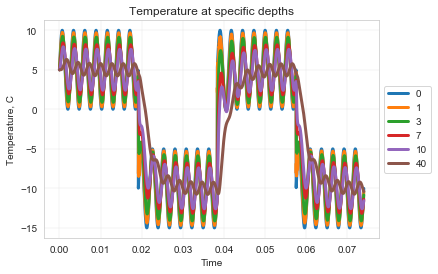

In [14]:
ftc.plot_depths("Temperature",[0,1,3,7,10,40])

### Concentrations of different species during the whole period of simulation:

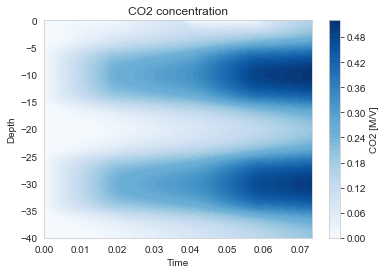

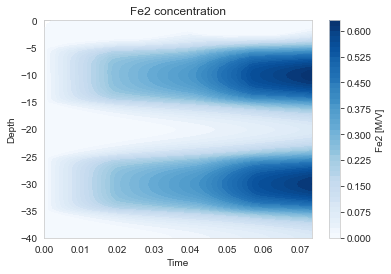

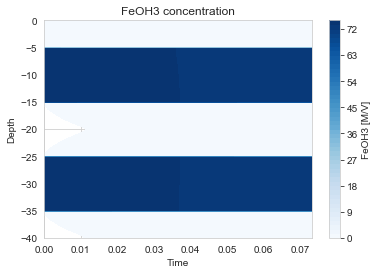

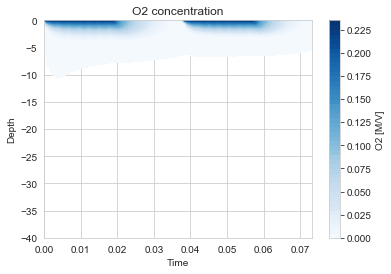

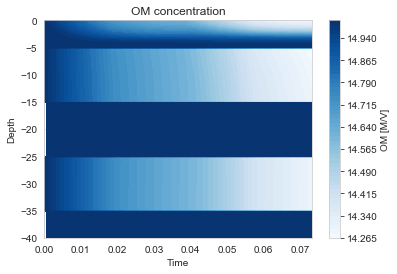

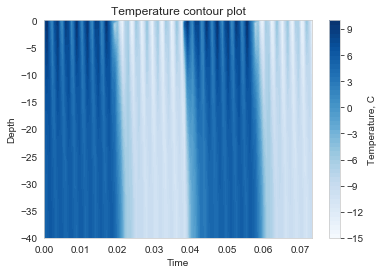

In [15]:
ftc.plot_contourplots()

### The rates of consumption and production of species:

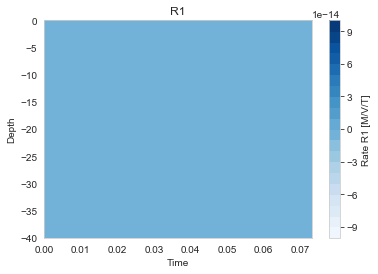

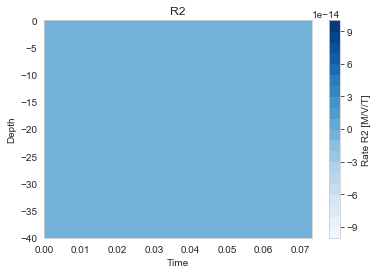

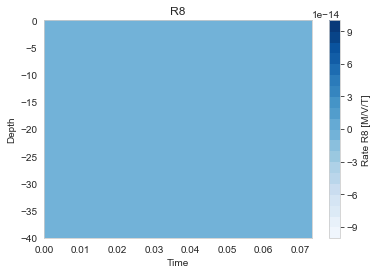

In [16]:
ftc.plot_contourplots_of_rates()

### Profiles at the end of the simulation

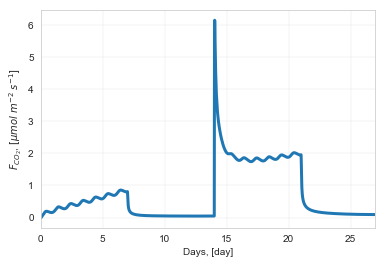

In [17]:
Fx = ftc.estimate_flux_at_top('CO2')
ftc.custom_plot(ftc.time*365, 10**4/(60*60*24)*Fx,x_lbl='Days, [day]' , y_lbl='$F_{CO_2}$, $[\mu mol$ $m^{-2}$ $s^{-1}]$')